# PyTorch

## Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [2]:
from get_images import get_images

In [3]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [4]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [5]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [6]:
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

## Mostrar imágenes 

In [7]:
x_test.shape

(10000, 784)

In [8]:
y_train.shape

(50000, 1)

In [9]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 1


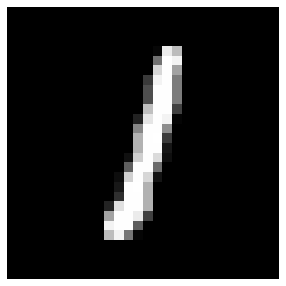

In [10]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [11]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [12]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cuda


## Compute accuracy 

In [17]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [23]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
    

## Modelo usando Sequential

In [31]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

Epoch: 0, costo: 1.8872113227844238, accuracy: 0.748291015625
Epoch: 1, costo: 1.2564311027526855, accuracy: 0.799560546875
Epoch: 2, costo: 0.8482204079627991, accuracy: 0.849609375
Epoch: 3, costo: 0.6459829807281494, accuracy: 0.866455078125
Epoch: 4, costo: 0.5570681095123291, accuracy: 0.880615234375
Epoch: 5, costo: 0.47360876202583313, accuracy: 0.889892578125
Epoch: 6, costo: 0.4567626714706421, accuracy: 0.899169921875
Epoch: 7, costo: 0.4052569568157196, accuracy: 0.903076171875
Epoch: 8, costo: 0.43109753727912903, accuracy: 0.908447265625
Epoch: 9, costo: 0.39147621393203735, accuracy: 0.8955078125
Epoch: 10, costo: 0.3300645649433136, accuracy: 0.909912109375
Epoch: 11, costo: 0.3304167091846466, accuracy: 0.904541015625
Epoch: 12, costo: 0.33912497758865356, accuracy: 0.911865234375
Epoch: 13, costo: 0.3583987355232239, accuracy: 0.912109375
Epoch: 14, costo: 0.2944585084915161, accuracy: 0.912353515625
Epoch: 15, costo: 0.2834382951259613, accuracy: 0.912109375
Epoch: 16

In [32]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.959228515625